In [5]:
from keras.models import load_model,Sequential
from keras.layers import Input, Dense, LSTM,Dropout
from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint


import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import confusion_matrix

def signal_to_catagorical(data):
  data.loc[data['Signal'] == 'wait ot hold', 'Signal'] = 'wait or hold'
  data.loc[data['Signal'] == 'buy', 'Signal'] = 0
  data.loc[data['Signal'] == 'sell', 'Signal'] = 1 
  data.loc[data['Signal'] == 'wait or hold', 'Signal'] = 2 
  return data

def add_shift_day(data,day):
  r_list = []
  for i in range(day,len(data)):#Number mean day to shift
    r_list.append(data[i-day : i])
  return np.array(r_list)



In [6]:
datalist = [f for f in glob.glob("Dataset/*.csv")]
print('have stock = ',len(datalist))


have stock =  76


In [7]:
data = pd.read_csv(datalist[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            3023 non-null   object 
 1   High            3023 non-null   float64
 2   Low             3023 non-null   float64
 3   Open            3023 non-null   float64
 4   Close           3023 non-null   float64
 5   Volume          3023 non-null   int64  
 6   Adj Close       3023 non-null   float64
 7   Signal          3023 non-null   object 
 8   MACD-1          3023 non-null   float64
 9   SIGNAL LINE1    3023 non-null   float64
 10  MACD-2          3023 non-null   float64
 11  SIGNAL LINE2    3023 non-null   float64
 12  plusDI          3023 non-null   float64
 13  minusDI         3023 non-null   float64
 14  adx             3023 non-null   float64
 15  storsi          3023 non-null   float64
 16  %K              3023 non-null   float64
 17  %D              3023 non-null   f

In [8]:
#validation 
val_list = []
for val_name in range(71,74):
    df = pd.read_csv(datalist[val_name])
    val_x = df
    # val_x = add_shift_day(val_x,30)
    val_list.append(val_x)

#test
test_list = []
for test_name in range(74,76):
    df = pd.read_csv(datalist[test_name])
    test = df
    # test = add_shift_day(test,30)
    test_list.append(test)

In [19]:
model = Sequential()
model.add(LSTM(100, input_shape=((30,6)),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

checkpoint = ModelCheckpoint('Model/lstm_model_trend2.h5',
                               verbose=1,
                               monitor='val_acc',
                               mode='max',
                               save_best_only = True)



In [ ]:
for train_name in range(0,70):
    try:
        df = pd.read_csv(datalist[train_name])
        df = signal_to_catagorical(df)
        df = df[30:]
        x_train = df[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','Close_n','AO_n','RSI_n']].values
        x_train = add_shift_day(x_train,30)
        y_train = df['Signal']
        y_train = to_categorical(y_train)
        y_train = y_train.tolist()
        del y_train[0:30]
        y_train = np.array(y_train)

        r = random.randint(0,2)
        val = val_list[1]
        val = signal_to_catagorical(val)
        x_val = val[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','Close_n','AO_n','RSI_n']].values
        x_val = add_shift_day(x_val,30)
        y_val = val['Signal']
        y_val = to_categorical(y_val)
        y_val = y_val.tolist()
        del y_val[0:30]
        y_val = np.array(y_val)

        h = model.fit(x_train, y_train, epochs=100,validation_data=(x_val,y_val),callbacks=[checkpoint],shuffle=False)
        model.save('Model train/model_lstm_'+str(datalist[train_name])+'.h5')
        plt.plot(h.history['acc'])
        plt.plot(h.history['val_acc'])
        plt.legend(['train', 'val'])
        plt.show()
    except:
        print(datalist[train_name])
        

Epoch 1/100
93/93 [==============================] - ETA: 0s - loss: 0.8242 - acc: 0.7030
Epoch 00001: val_acc improved from -inf to 0.59778, saving model to Model\lstm_model_trend2.h5
93/93 [==============================] - 6s 60ms/step - loss: 0.8242 - acc: 0.7030 - val_loss: 1.0931 - val_acc: 0.5978
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 0.7141 - acc: 0.7297
Epoch 00002: val_acc improved from 0.59778 to 0.61463, saving model to Model\lstm_model_trend2.h5
93/93 [==============================] - 5s 51ms/step - loss: 0.7141 - acc: 0.7297 - val_loss: 1.0551 - val_acc: 0.6146
Epoch 3/100
92/93 [============================>.] - ETA: 0s - loss: 0.6942 - acc: 0.7286
Epoch 00003: val_acc improved from 0.61463 to 0.61750, saving model to Model\lstm_model_trend2.h5
93/93 [==============================] - 5s 52ms/step - loss: 0.6928 - acc: 0.7297 - val_loss: 0.9132 - val_acc: 0.6175
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 0.6589 - a

Epoch 32/100
92/93 [============================>.] - ETA: 0s - loss: 0.5399 - acc: 0.7687
Epoch 00032: val_acc did not improve from 0.61791
93/93 [==============================] - 5s 56ms/step - loss: 0.5399 - acc: 0.7685 - val_loss: 1.1141 - val_acc: 0.6179
Epoch 33/100
93/93 [==============================] - ETA: 0s - loss: 0.5195 - acc: 0.7715
Epoch 00033: val_acc did not improve from 0.61791
93/93 [==============================] - 4s 46ms/step - loss: 0.5195 - acc: 0.7715 - val_loss: 1.3022 - val_acc: 0.6150
Epoch 34/100
93/93 [==============================] - ETA: 0s - loss: 0.5371 - acc: 0.7796
Epoch 00034: val_acc did not improve from 0.61791
93/93 [==============================] - 4s 48ms/step - loss: 0.5371 - acc: 0.7796 - val_loss: 1.1649 - val_acc: 0.6085
Epoch 35/100
93/93 [==============================] - ETA: 0s - loss: 0.4977 - acc: 0.7955
Epoch 00035: val_acc did not improve from 0.61791
93/93 [==============================] - 4s 46ms/step - loss: 0.4977 - acc: 

93/93 [==============================] - ETA: 0s - loss: 0.3287 - acc: 0.8721
Epoch 00094: val_acc did not improve from 0.62243
93/93 [==============================] - 5s 52ms/step - loss: 0.3287 - acc: 0.8721 - val_loss: 1.9873 - val_acc: 0.6134
Epoch 95/100
93/93 [==============================] - ETA: 0s - loss: 0.2347 - acc: 0.9102- ETA: 0s - loss: 0.2397 - a
Epoch 00095: val_acc did not improve from 0.62243
93/93 [==============================] - 5s 53ms/step - loss: 0.2347 - acc: 0.9102 - val_loss: 2.0776 - val_acc: 0.6118
Epoch 96/100
92/93 [============================>.] - ETA: 0s - loss: 0.1878 - acc: 0.9304
Epoch 00096: val_acc did not improve from 0.62243
93/93 [==============================] - 5s 52ms/step - loss: 0.1873 - acc: 0.9305 - val_loss: 2.1967 - val_acc: 0.6085
Epoch 97/100
92/93 [============================>.] - ETA: 0s - loss: 0.1588 - acc: 0.9436
Epoch 00097: val_acc did not improve from 0.62243
93/93 [==============================] - 5s 53ms/step - loss:

Epoch 25/100
70/70 [==============================] - ETA: 0s - loss: 0.2926 - acc: 0.8637
Epoch 00025: val_acc did not improve from 0.62572
70/70 [==============================] - 4s 58ms/step - loss: 0.2926 - acc: 0.8637 - val_loss: 1.6749 - val_acc: 0.6113
Epoch 26/100
69/70 [============================>.] - ETA: 0s - loss: 0.3161 - acc: 0.8542
Epoch 00026: val_acc did not improve from 0.62572
70/70 [==============================] - 4s 58ms/step - loss: 0.3160 - acc: 0.8542 - val_loss: 1.5685 - val_acc: 0.6179
Epoch 27/100
69/70 [============================>.] - ETA: 0s - loss: 0.3143 - acc: 0.8691
Epoch 00027: val_acc improved from 0.62572 to 0.62654, saving model to Model\lstm_model_trend2.h5
70/70 [==============================] - 4s 58ms/step - loss: 0.3141 - acc: 0.8692 - val_loss: 1.5376 - val_acc: 0.6265
Epoch 28/100
69/70 [============================>.] - ETA: 0s - loss: 0.3647 - acc: 0.8152
Epoch 00028: val_acc did not improve from 0.62654
70/70 [=====================

69/70 [============================>.] - ETA: 0s - loss: 0.3032 - acc: 0.8936
Epoch 00087: val_acc did not improve from 0.62654
70/70 [==============================] - 4s 55ms/step - loss: 0.3030 - acc: 0.8936 - val_loss: 1.9626 - val_acc: 0.5916
Epoch 88/100
69/70 [============================>.] - ETA: 0s - loss: 0.2520 - acc: 0.9135
Epoch 00088: val_acc did not improve from 0.62654
70/70 [==============================] - 4s 53ms/step - loss: 0.2518 - acc: 0.9135 - val_loss: 1.7232 - val_acc: 0.5661
Epoch 89/100
69/70 [============================>.] - ETA: 0s - loss: 0.1519 - acc: 0.9466
Epoch 00089: val_acc did not improve from 0.62654
70/70 [==============================] - 4s 50ms/step - loss: 0.1519 - acc: 0.9466 - val_loss: 1.9338 - val_acc: 0.5703
Epoch 90/100
69/70 [============================>.] - ETA: 0s - loss: 0.0859 - acc: 0.9719
Epoch 00090: val_acc did not improve from 0.62654
70/70 [==============================] - 4s 52ms/step - loss: 0.0858 - acc: 0.9719 - val_

Epoch 50/100
77/77 [==============================] - ETA: 0s - loss: 0.0346 - acc: 0.9890
Epoch 00050: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 53ms/step - loss: 0.0346 - acc: 0.9890 - val_loss: 2.4635 - val_acc: 0.5193
Epoch 51/100
77/77 [==============================] - ETA: 0s - loss: 0.0305 - acc: 0.9898
Epoch 00051: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 52ms/step - loss: 0.0305 - acc: 0.9898 - val_loss: 2.4625 - val_acc: 0.5456
Epoch 52/100
77/77 [==============================] - ETA: 0s - loss: 0.0286 - acc: 0.9902
Epoch 00052: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 51ms/step - loss: 0.0286 - acc: 0.9902 - val_loss: 2.5342 - val_acc: 0.5357
Epoch 53/100
76/77 [============================>.] - ETA: 0s - loss: 0.0593 - acc: 0.9794
Epoch 00053: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 50ms/step - loss: 0.0595 - acc: 

Epoch 82/100
76/77 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9630
Epoch 00082: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 53ms/step - loss: 0.0844 - acc: 0.9630 - val_loss: 2.5092 - val_acc: 0.5440
Epoch 83/100
77/77 [==============================] - ETA: 0s - loss: 0.0528 - acc: 0.9801
Epoch 00083: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 55ms/step - loss: 0.0528 - acc: 0.9801 - val_loss: 2.4518 - val_acc: 0.5472
Epoch 84/100
76/77 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9848
Epoch 00084: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 55ms/step - loss: 0.0385 - acc: 0.9850 - val_loss: 2.4620 - val_acc: 0.5460
Epoch 85/100
77/77 [==============================] - ETA: 0s - loss: 0.0283 - acc: 0.9915
Epoch 00085: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 51ms/step - loss: 0.0283 - acc: 

77/77 [==============================] - ETA: 0s - loss: 0.0161 - acc: 0.9955
Epoch 00044: val_acc did not improve from 0.62654
77/77 [==============================] - 5s 59ms/step - loss: 0.0161 - acc: 0.9955 - val_loss: 2.7591 - val_acc: 0.6159
Epoch 45/100
77/77 [==============================] - ETA: 0s - loss: 0.0158 - acc: 0.9947
Epoch 00045: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 56ms/step - loss: 0.0158 - acc: 0.9947 - val_loss: 2.8160 - val_acc: 0.6187
Epoch 46/100
76/77 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9967- ETA: 2s - 
Epoch 00046: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 58ms/step - loss: 0.0158 - acc: 0.9963 - val_loss: 2.8211 - val_acc: 0.6138
Epoch 47/100
77/77 [==============================] - ETA: 0s - loss: 0.0225 - acc: 0.9906
Epoch 00047: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 57ms/step - loss: 0.0225 - acc: 0

Epoch 7/100
93/94 [============================>.] - ETA: 0s - loss: 0.5188 - acc: 0.7681
Epoch 00007: val_acc did not improve from 0.62654
94/94 [==============================] - 5s 49ms/step - loss: 0.5153 - acc: 0.7702 - val_loss: 1.0631 - val_acc: 0.5929
Epoch 8/100
93/94 [============================>.] - ETA: 0s - loss: 0.4927 - acc: 0.7917
Epoch 00008: val_acc did not improve from 0.62654
94/94 [==============================] - 5s 50ms/step - loss: 0.4893 - acc: 0.7935 - val_loss: 1.0937 - val_acc: 0.5887
Epoch 9/100
93/94 [============================>.] - ETA: 0s - loss: 0.5219 - acc: 0.7698
Epoch 00009: val_acc did not improve from 0.62654
94/94 [==============================] - 5s 50ms/step - loss: 0.5185 - acc: 0.7718 - val_loss: 1.1044 - val_acc: 0.5879
Epoch 10/100
93/94 [============================>.] - ETA: 0s - loss: 0.4849 - acc: 0.7839
Epoch 00010: val_acc did not improve from 0.62654
94/94 [==============================] - 5s 50ms/step - loss: 0.4813 - acc: 0.7

Epoch 70/100
93/94 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9882
Epoch 00070: val_acc did not improve from 0.62654
94/94 [==============================] - 5s 50ms/step - loss: 0.0317 - acc: 0.9883 - val_loss: 2.6332 - val_acc: 0.5497
Epoch 71/100
93/94 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9882
Epoch 00071: val_acc did not improve from 0.62654
94/94 [==============================] - 4s 46ms/step - loss: 0.0321 - acc: 0.9883 - val_loss: 2.5941 - val_acc: 0.5366
Epoch 72/100
93/94 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9923
Epoch 00072: val_acc did not improve from 0.62654
94/94 [==============================] - 5s 50ms/step - loss: 0.0240 - acc: 0.9923 - val_loss: 2.6332 - val_acc: 0.5411
Epoch 73/100
93/94 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9842
Epoch 00073: val_acc did not improve from 0.62654
94/94 [==============================] - 5s 50ms/step - loss: 0.0388 - acc: 

Epoch 33/100
77/77 [==============================] - ETA: 0s - loss: 0.0621 - acc: 0.9768
Epoch 00033: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 50ms/step - loss: 0.0621 - acc: 0.9768 - val_loss: 2.7274 - val_acc: 0.5937
Epoch 34/100
77/77 [==============================] - ETA: 0s - loss: 0.0547 - acc: 0.9817
Epoch 00034: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 49ms/step - loss: 0.0547 - acc: 0.9817 - val_loss: 2.7369 - val_acc: 0.5842
Epoch 35/100
77/77 [==============================] - ETA: 0s - loss: 0.0532 - acc: 0.9825
Epoch 00035: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 53ms/step - loss: 0.0532 - acc: 0.9825 - val_loss: 2.8030 - val_acc: 0.5785
Epoch 36/100
76/77 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9827
Epoch 00036: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 52ms/step - loss: 0.0474 - acc: 

Epoch 65/100
77/77 [==============================] - ETA: 0s - loss: 0.0322 - acc: 0.9894
Epoch 00065: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 51ms/step - loss: 0.0322 - acc: 0.9894 - val_loss: 2.8478 - val_acc: 0.5822
Epoch 66/100
77/77 [==============================] - ETA: 0s - loss: 0.0220 - acc: 0.9935
Epoch 00066: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 52ms/step - loss: 0.0220 - acc: 0.9935 - val_loss: 2.8684 - val_acc: 0.5830
Epoch 67/100
77/77 [==============================] - ETA: 0s - loss: 0.0173 - acc: 0.9951
Epoch 00067: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 53ms/step - loss: 0.0173 - acc: 0.9951 - val_loss: 3.0032 - val_acc: 0.5867
Epoch 68/100
77/77 [==============================] - ETA: 0s - loss: 0.0163 - acc: 0.9951
Epoch 00068: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 52ms/step - loss: 0.0163 - acc: 

Epoch 97/100
77/77 [==============================] - ETA: 0s - loss: 0.0203 - acc: 0.9939
Epoch 00097: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 54ms/step - loss: 0.0203 - acc: 0.9939 - val_loss: 3.4962 - val_acc: 0.5883
Epoch 98/100
77/77 [==============================] - ETA: 0s - loss: 0.0186 - acc: 0.9915
Epoch 00098: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 50ms/step - loss: 0.0186 - acc: 0.9915 - val_loss: 3.2349 - val_acc: 0.5978
Epoch 99/100
77/77 [==============================] - ETA: 0s - loss: 0.0209 - acc: 0.9915
Epoch 00099: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 51ms/step - loss: 0.0209 - acc: 0.9915 - val_loss: 3.5622 - val_acc: 0.5850
Epoch 100/100
77/77 [==============================] - ETA: 0s - loss: 0.0206 - acc: 0.9919
Epoch 00100: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 52ms/step - loss: 0.0206 - acc:

76/77 [============================>.] - ETA: 0s - loss: 0.0802 - acc: 0.9642
Epoch 00059: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 52ms/step - loss: 0.0796 - acc: 0.9646 - val_loss: 2.6534 - val_acc: 0.5760
Epoch 60/100
77/77 [==============================] - ETA: 0s - loss: 0.0894 - acc: 0.9654
Epoch 00060: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 51ms/step - loss: 0.0894 - acc: 0.9654 - val_loss: 2.6916 - val_acc: 0.5842
Epoch 61/100
77/77 [==============================] - ETA: 0s - loss: 0.0794 - acc: 0.9654
Epoch 00061: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 53ms/step - loss: 0.0794 - acc: 0.9654 - val_loss: 2.7128 - val_acc: 0.5863
Epoch 62/100
77/77 [==============================] - ETA: 0s - loss: 0.0753 - acc: 0.9703
Epoch 00062: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 53ms/step - loss: 0.0753 - acc: 0.9703 - val_

Epoch 91/100
76/77 [============================>.] - ETA: 0s - loss: 0.0805 - acc: 0.9659
Epoch 00091: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 58ms/step - loss: 0.0801 - acc: 0.9658 - val_loss: 3.0092 - val_acc: 0.5965
Epoch 92/100
76/77 [============================>.] - ETA: 0s - loss: 0.1291 - acc: 0.9560
Epoch 00092: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 58ms/step - loss: 0.1279 - acc: 0.9565 - val_loss: 2.8705 - val_acc: 0.5945
Epoch 93/100
77/77 [==============================] - ETA: 0s - loss: 0.1419 - acc: 0.9418
Epoch 00093: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 52ms/step - loss: 0.1419 - acc: 0.9418 - val_loss: 2.7428 - val_acc: 0.5896
Epoch 94/100
77/77 [==============================] - ETA: 0s - loss: 0.1523 - acc: 0.9394
Epoch 00094: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 51ms/step - loss: 0.1523 - acc: 

Epoch 54/100
77/77 [==============================] - ETA: 0s - loss: 0.1480 - acc: 0.9516
Epoch 00054: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 51ms/step - loss: 0.1480 - acc: 0.9516 - val_loss: 2.6293 - val_acc: 0.6196
Epoch 55/100
77/77 [==============================] - ETA: 0s - loss: 0.0767 - acc: 0.9695
Epoch 00055: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 47ms/step - loss: 0.0767 - acc: 0.9695 - val_loss: 2.6974 - val_acc: 0.6093
Epoch 56/100
77/77 [==============================] - ETA: 0s - loss: 0.0377 - acc: 0.9862
Epoch 00056: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 48ms/step - loss: 0.0377 - acc: 0.9862 - val_loss: 2.7386 - val_acc: 0.6138
Epoch 57/100
77/77 [==============================] - ETA: 0s - loss: 0.0206 - acc: 0.9951
Epoch 00057: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 51ms/step - loss: 0.0206 - acc: 

Epoch 86/100
77/77 [==============================] - ETA: 0s - loss: 0.0199 - acc: 0.9923
Epoch 00086: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 47ms/step - loss: 0.0199 - acc: 0.9923 - val_loss: 3.0998 - val_acc: 0.6118
Epoch 87/100
77/77 [==============================] - ETA: 0s - loss: 0.0241 - acc: 0.9923
Epoch 00087: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 48ms/step - loss: 0.0241 - acc: 0.9923 - val_loss: 3.1371 - val_acc: 0.6031
Epoch 88/100
77/77 [==============================] - ETA: 0s - loss: 0.0305 - acc: 0.9902
Epoch 00088: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 50ms/step - loss: 0.0305 - acc: 0.9902 - val_loss: 3.1050 - val_acc: 0.5998
Epoch 89/100
77/77 [==============================] - ETA: 0s - loss: 0.0292 - acc: 0.9906
Epoch 00089: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 51ms/step - loss: 0.0292 - acc: 

Epoch 49/100
77/77 [==============================] - ETA: 0s - loss: 0.0913 - acc: 0.9707
Epoch 00049: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 50ms/step - loss: 0.0913 - acc: 0.9707 - val_loss: 2.8030 - val_acc: 0.5883
Epoch 50/100
77/77 [==============================] - ETA: 0s - loss: 0.1691 - acc: 0.9455
Epoch 00050: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 51ms/step - loss: 0.1691 - acc: 0.9455 - val_loss: 2.6901 - val_acc: 0.5645
Epoch 51/100
77/77 [==============================] - ETA: 0s - loss: 0.1314 - acc: 0.9545
Epoch 00051: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 50ms/step - loss: 0.1314 - acc: 0.9545 - val_loss: 2.6184 - val_acc: 0.5904
Epoch 52/100
77/77 [==============================] - ETA: 0s - loss: 0.0611 - acc: 0.9752
Epoch 00052: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 47ms/step - loss: 0.0611 - acc: 

Epoch 81/100
77/77 [==============================] - ETA: 0s - loss: 0.2694 - acc: 0.9398
Epoch 00081: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 52ms/step - loss: 0.2694 - acc: 0.9398 - val_loss: 2.5556 - val_acc: 0.5452
Epoch 82/100
77/77 [==============================] - ETA: 0s - loss: 0.0866 - acc: 0.9707
Epoch 00082: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 48ms/step - loss: 0.0866 - acc: 0.9707 - val_loss: 2.4441 - val_acc: 0.5357
Epoch 83/100
77/77 [==============================] - ETA: 0s - loss: 0.0488 - acc: 0.9841
Epoch 00083: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 51ms/step - loss: 0.0488 - acc: 0.9841 - val_loss: 2.5709 - val_acc: 0.5419
Epoch 84/100
77/77 [==============================] - ETA: 0s - loss: 0.0190 - acc: 0.9939
Epoch 00084: val_acc did not improve from 0.62654
77/77 [==============================] - 4s 52ms/step - loss: 0.0190 - acc: 

Epoch 44/100
85/86 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9812
Epoch 00044: val_acc did not improve from 0.62654
86/86 [==============================] - 4s 51ms/step - loss: 0.0500 - acc: 0.9813 - val_loss: 2.3054 - val_acc: 0.6085
Epoch 45/100
85/86 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9908
Epoch 00045: val_acc did not improve from 0.62654
86/86 [==============================] - 4s 51ms/step - loss: 0.0258 - acc: 0.9908 - val_loss: 2.4224 - val_acc: 0.6204
Epoch 46/100
85/86 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9901
Epoch 00046: val_acc did not improve from 0.62654
86/86 [==============================] - 4s 48ms/step - loss: 0.0315 - acc: 0.9901 - val_loss: 2.3214 - val_acc: 0.6224
Epoch 47/100
85/86 [============================>.] - ETA: 0s - loss: 0.0223 - acc: 0.9923
Epoch 00047: val_acc did not improve from 0.62654
86/86 [==============================] - 4s 49ms/step - loss: 0.0222 - acc: 

75/76 [============================>.] - ETA: 0s - loss: 0.4476 - acc: 0.7887
Epoch 00006: val_acc did not improve from 0.62859
76/76 [==============================] - 5s 60ms/step - loss: 0.4468 - acc: 0.7893 - val_loss: 1.2234 - val_acc: 0.6237
Epoch 7/100
76/76 [==============================] - ETA: 0s - loss: 0.4248 - acc: 0.7959- ETA: 2s
Epoch 00007: val_acc did not improve from 0.62859
76/76 [==============================] - 5s 61ms/step - loss: 0.4248 - acc: 0.7959 - val_loss: 1.2526 - val_acc: 0.6282
Epoch 8/100
75/76 [============================>.] - ETA: 0s - loss: 0.3907 - acc: 0.8125
Epoch 00008: val_acc did not improve from 0.62859
76/76 [==============================] - 4s 57ms/step - loss: 0.3900 - acc: 0.8130 - val_loss: 1.2968 - val_acc: 0.6237
Epoch 9/100
76/76 [==============================] - ETA: 0s - loss: 0.3636 - acc: 0.8184
Epoch 00009: val_acc did not improve from 0.62859
76/76 [==============================] - 4s 58ms/step - loss: 0.3636 - acc: 0.8184 

Epoch 37/100
75/76 [============================>.] - ETA: 0s - loss: 0.0691 - acc: 0.9771
Epoch 00037: val_acc did not improve from 0.63353
76/76 [==============================] - 6s 74ms/step - loss: 0.0690 - acc: 0.9771 - val_loss: 2.4056 - val_acc: 0.6126
Epoch 38/100
75/76 [============================>.] - ETA: 0s - loss: 0.0765 - acc: 0.9733
Epoch 00038: val_acc did not improve from 0.63353
76/76 [==============================] - 6s 74ms/step - loss: 0.0764 - acc: 0.9734 - val_loss: 2.4261 - val_acc: 0.6011
Epoch 39/100
75/76 [============================>.] - ETA: 0s - loss: 0.1372 - acc: 0.9571
Epoch 00039: val_acc did not improve from 0.63353
76/76 [==============================] - 6s 79ms/step - loss: 0.1369 - acc: 0.9572 - val_loss: 2.3445 - val_acc: 0.6159
Epoch 40/100
75/76 [============================>.] - ETA: 0s - loss: 0.2709 - acc: 0.9171
Epoch 00040: val_acc did not improve from 0.63353
76/76 [==============================] - 6s 79ms/step - loss: 0.2703 - acc: 

Epoch 68/100
76/76 [==============================] - ETA: 0s - loss: 0.0302 - acc: 0.9900
Epoch 00068: val_acc did not improve from 0.63353
76/76 [==============================] - 5s 62ms/step - loss: 0.0302 - acc: 0.9900 - val_loss: 2.6203 - val_acc: 0.6011
Epoch 69/100
75/76 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9929
Epoch 00069: val_acc did not improve from 0.63353
76/76 [==============================] - 5s 66ms/step - loss: 0.0231 - acc: 0.9929 - val_loss: 2.7904 - val_acc: 0.5912
Epoch 70/100
75/76 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9900
Epoch 00070: val_acc did not improve from 0.63353
76/76 [==============================] - 6s 74ms/step - loss: 0.0375 - acc: 0.9900 - val_loss: 2.6300 - val_acc: 0.5965
Epoch 71/100
75/76 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9846- ETA: 1s - loss: 0.0424 - 
Epoch 00071: val_acc did not improve from 0.63353
76/76 [==============================] - 5s 63ms/

Epoch 30/100
85/86 [============================>.] - ETA: 0s - loss: 0.0185 - acc: 0.9945
Epoch 00030: val_acc did not improve from 0.63353
86/86 [==============================] - 6s 75ms/step - loss: 0.0185 - acc: 0.9945 - val_loss: 3.5212 - val_acc: 0.6224
Epoch 31/100
85/86 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9963
Epoch 00031: val_acc did not improve from 0.63353
86/86 [==============================] - 6s 72ms/step - loss: 0.0125 - acc: 0.9963 - val_loss: 3.5761 - val_acc: 0.6200
Epoch 32/100
86/86 [==============================] - ETA: 0s - loss: 0.0115 - acc: 0.9963
Epoch 00032: val_acc did not improve from 0.63353
86/86 [==============================] - 7s 87ms/step - loss: 0.0115 - acc: 0.9963 - val_loss: 3.5945 - val_acc: 0.6208
Epoch 33/100
85/86 [============================>.] - ETA: 0s - loss: 0.0157 - acc: 0.9934
Epoch 00033: val_acc did not improve from 0.63353
86/86 [==============================] - 6s 72ms/step - loss: 0.0156 - acc: 

Epoch 92/100
85/86 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9882
Epoch 00092: val_acc did not improve from 0.63558
86/86 [==============================] - 6s 72ms/step - loss: 0.0314 - acc: 0.9883 - val_loss: 3.6254 - val_acc: 0.6278
Epoch 93/100
86/86 [==============================] - ETA: 0s - loss: 0.0182 - acc: 0.9930
Epoch 00093: val_acc did not improve from 0.63558
86/86 [==============================] - 7s 81ms/step - loss: 0.0182 - acc: 0.9930 - val_loss: 3.7782 - val_acc: 0.6302
Epoch 94/100
85/86 [============================>.] - ETA: 0s - loss: 0.0119 - acc: 0.9967
Epoch 00094: val_acc did not improve from 0.63558
86/86 [==============================] - 7s 82ms/step - loss: 0.0118 - acc: 0.9967 - val_loss: 3.8347 - val_acc: 0.6294
Epoch 95/100
85/86 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9967
Epoch 00095: val_acc did not improve from 0.63558
86/86 [==============================] - 6s 67ms/step - loss: 0.0085 - acc: 

77/77 [==============================] - ETA: 0s - loss: 0.0088 - acc: 0.9967
Epoch 00054: val_acc did not improve from 0.63558
77/77 [==============================] - 8s 110ms/step - loss: 0.0088 - acc: 0.9967 - val_loss: 3.2980 - val_acc: 0.5727
Epoch 55/100
77/77 [==============================] - ETA: 0s - loss: 0.0083 - acc: 0.9959
Epoch 00055: val_acc did not improve from 0.63558
77/77 [==============================] - 8s 100ms/step - loss: 0.0083 - acc: 0.9959 - val_loss: 3.2480 - val_acc: 0.5723
Epoch 56/100
77/77 [==============================] - ETA: 0s - loss: 0.0067 - acc: 0.9972
Epoch 00056: val_acc did not improve from 0.63558
77/77 [==============================] - 8s 99ms/step - loss: 0.0067 - acc: 0.9972 - val_loss: 3.3660 - val_acc: 0.5731
Epoch 57/100
77/77 [==============================] - ETA: 0s - loss: 0.0054 - acc: 0.9984
Epoch 00057: val_acc did not improve from 0.63558
77/77 [==============================] - 9s 113ms/step - loss: 0.0054 - acc: 0.9984 - v

Epoch 16/100
89/90 [============================>.] - ETA: 0s - loss: 0.2677 - acc: 0.8838
Epoch 00016: val_acc did not improve from 0.63558
90/90 [==============================] - 6s 62ms/step - loss: 0.2669 - acc: 0.8842 - val_loss: 2.5942 - val_acc: 0.5144
Epoch 17/100
89/90 [============================>.] - ETA: 0s - loss: 0.2186 - acc: 0.9077
Epoch 00017: val_acc did not improve from 0.63558
90/90 [==============================] - 8s 86ms/step - loss: 0.2179 - acc: 0.9080 - val_loss: 2.6429 - val_acc: 0.5185
Epoch 18/100
89/90 [============================>.] - ETA: 0s - loss: 0.2116 - acc: 0.9126
Epoch 00018: val_acc did not improve from 0.63558
90/90 [==============================] - 6s 68ms/step - loss: 0.2109 - acc: 0.9129 - val_loss: 2.6435 - val_acc: 0.5403
Epoch 19/100
89/90 [============================>.] - ETA: 0s - loss: 0.2967 - acc: 0.8750
Epoch 00019: val_acc did not improve from 0.63558
90/90 [==============================] - 6s 67ms/step - loss: 0.2958 - acc: 

90/90 [==============================] - ETA: 0s - loss: 0.0223 - acc: 0.9927
Epoch 00078: val_acc did not improve from 0.63558
90/90 [==============================] - 6s 67ms/step - loss: 0.0223 - acc: 0.9927 - val_loss: 3.6813 - val_acc: 0.5316
Epoch 79/100
89/90 [============================>.] - ETA: 0s - loss: 0.0187 - acc: 0.9940- ETA: 1s - loss: 0.
Epoch 00079: val_acc did not improve from 0.63558
90/90 [==============================] - 6s 69ms/step - loss: 0.0187 - acc: 0.9941 - val_loss: 3.8207 - val_acc: 0.5238
Epoch 80/100
89/90 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9937
Epoch 00080: val_acc did not improve from 0.63558
90/90 [==============================] - 6s 69ms/step - loss: 0.0183 - acc: 0.9937 - val_loss: 3.7069 - val_acc: 0.5386
Epoch 81/100
90/90 [==============================] - ETA: 0s - loss: 0.0208 - acc: 0.9937
Epoch 00081: val_acc did not improve from 0.63558
90/90 [==============================] - 7s 74ms/step - loss: 0.0208 

80/81 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9937
Epoch 00040: val_acc did not improve from 0.63558
81/81 [==============================] - 7s 90ms/step - loss: 0.0259 - acc: 0.9938 - val_loss: 2.9165 - val_acc: 0.5472
Epoch 41/100
80/81 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9918
Epoch 00041: val_acc did not improve from 0.63558
81/81 [==============================] - 6s 74ms/step - loss: 0.0242 - acc: 0.9918 - val_loss: 2.9911 - val_acc: 0.5341
Epoch 42/100
80/81 [============================>.] - ETA: 0s - loss: 0.0529 - acc: 0.9828
Epoch 00042: val_acc did not improve from 0.63558
81/81 [==============================] - 6s 73ms/step - loss: 0.0528 - acc: 0.9828 - val_loss: 3.0554 - val_acc: 0.5292
Epoch 43/100
80/81 [============================>.] - ETA: 0s - loss: 0.0642 - acc: 0.9793- ETA: 0s - loss: 0.06
Epoch 00043: val_acc did not improve from 0.63558
81/81 [==============================] - 6s 72ms/step - loss: 0.064

Epoch 71/100
81/81 [==============================] - ETA: 0s - loss: 0.0147 - acc: 0.9945
Epoch 00071: val_acc did not improve from 0.63558
81/81 [==============================] - 8s 94ms/step - loss: 0.0147 - acc: 0.9945 - val_loss: 3.3898 - val_acc: 0.5505
Epoch 72/100
80/81 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9969
Epoch 00072: val_acc did not improve from 0.63558
81/81 [==============================] - 6s 69ms/step - loss: 0.0105 - acc: 0.9969 - val_loss: 3.4721 - val_acc: 0.5477
Epoch 73/100
80/81 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9949
Epoch 00073: val_acc did not improve from 0.63558
81/81 [==============================] - 6s 72ms/step - loss: 0.0120 - acc: 0.9949 - val_loss: 3.5513 - val_acc: 0.5485
Epoch 74/100
80/81 [============================>.] - ETA: 0s - loss: 0.0109 - acc: 0.9953
Epoch 00074: val_acc did not improve from 0.63558
81/81 [==============================] - 6s 75ms/step - loss: 0.0109 - acc: 

Epoch 2/100
77/77 [==============================] - ETA: 0s - loss: 0.8021 - acc: 0.6800
Epoch 00002: val_acc did not improve from 0.63558
77/77 [==============================] - 7s 90ms/step - loss: 0.8021 - acc: 0.6800 - val_loss: 1.5171 - val_acc: 0.6052
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 0.6743 - acc: 0.7190
Epoch 00003: val_acc did not improve from 0.63558
77/77 [==============================] - 5s 71ms/step - loss: 0.6743 - acc: 0.7190 - val_loss: 1.4423 - val_acc: 0.5912
Epoch 4/100
77/77 [==============================] - ETA: 0s - loss: 0.6569 - acc: 0.7145
Epoch 00004: val_acc did not improve from 0.63558
77/77 [==============================] - 6s 76ms/step - loss: 0.6569 - acc: 0.7145 - val_loss: 1.5146 - val_acc: 0.5867
Epoch 5/100
77/77 [==============================] - ETA: 0s - loss: 0.6233 - acc: 0.7088
Epoch 00005: val_acc did not improve from 0.63558
77/77 [==============================] - 6s 74ms/step - loss: 0.6233 - acc: 0.70

Epoch 64/100
77/77 [==============================] - ETA: 0s - loss: 0.0611 - acc: 0.9756
Epoch 00064: val_acc did not improve from 0.63558
77/77 [==============================] - 5s 60ms/step - loss: 0.0611 - acc: 0.9756 - val_loss: 3.4462 - val_acc: 0.6060
Epoch 65/100
76/77 [============================>.] - ETA: 0s - loss: 0.0590 - acc: 0.9799
Epoch 00065: val_acc did not improve from 0.63558
77/77 [==============================] - 5s 64ms/step - loss: 0.0583 - acc: 0.9801 - val_loss: 3.4800 - val_acc: 0.6101
Epoch 66/100
76/77 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9877
Epoch 00066: val_acc did not improve from 0.63558
77/77 [==============================] - 5s 64ms/step - loss: 0.0328 - acc: 0.9878 - val_loss: 3.5416 - val_acc: 0.6027
Epoch 67/100
77/77 [==============================] - ETA: 0s - loss: 0.0337 - acc: 0.9898
Epoch 00067: val_acc did not improve from 0.63558
77/77 [==============================] - 7s 85ms/step - loss: 0.0337 - acc: 

77/77 [==============================] - ETA: 0s - loss: 0.1202 - acc: 0.9553
Epoch 00026: val_acc did not improve from 0.63558
77/77 [==============================] - 7s 90ms/step - loss: 0.1202 - acc: 0.9553 - val_loss: 2.4547 - val_acc: 0.5879
Epoch 27/100
77/77 [==============================] - ETA: 0s - loss: 0.1169 - acc: 0.9593
Epoch 00027: val_acc did not improve from 0.63558
77/77 [==============================] - 7s 87ms/step - loss: 0.1169 - acc: 0.9593 - val_loss: 2.3125 - val_acc: 0.6044
Epoch 28/100
77/77 [==============================] - ETA: 0s - loss: 0.1178 - acc: 0.9573
Epoch 00028: val_acc did not improve from 0.63558
77/77 [==============================] - 8s 107ms/step - loss: 0.1178 - acc: 0.9573 - val_loss: 2.3317 - val_acc: 0.6023
Epoch 29/100
77/77 [==============================] - ETA: 0s - loss: 0.0845 - acc: 0.9683
Epoch 00029: val_acc did not improve from 0.63558
77/77 [==============================] - 6s 75ms/step - loss: 0.0845 - acc: 0.9683 - val

Epoch 57/100
77/77 [==============================] - ETA: 0s - loss: 0.0188 - acc: 0.9935
Epoch 00057: val_acc did not improve from 0.63558
77/77 [==============================] - 5s 71ms/step - loss: 0.0188 - acc: 0.9935 - val_loss: 3.0632 - val_acc: 0.5867
Epoch 58/100
77/77 [==============================] - ETA: 0s - loss: 0.0404 - acc: 0.9858
Epoch 00058: val_acc did not improve from 0.63558
77/77 [==============================] - 6s 74ms/step - loss: 0.0404 - acc: 0.9858 - val_loss: 3.0456 - val_acc: 0.5863
Epoch 59/100
77/77 [==============================] - ETA: 0s - loss: 0.0241 - acc: 0.9915
Epoch 00059: val_acc did not improve from 0.63558
77/77 [==============================] - 7s 89ms/step - loss: 0.0241 - acc: 0.9915 - val_loss: 3.0424 - val_acc: 0.5900
Epoch 60/100
76/77 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9901
Epoch 00060: val_acc did not improve from 0.63558
77/77 [==============================] - 5s 65ms/step - loss: 0.0265 - acc: 

86/87 [============================>.] - ETA: 0s - loss: 0.0621 - acc: 0.9793
Epoch 00019: val_acc did not improve from 0.63558
87/87 [==============================] - 5s 60ms/step - loss: 0.0616 - acc: 0.9795 - val_loss: 2.4089 - val_acc: 0.6105
Epoch 20/100
87/87 [==============================] - ETA: 0s - loss: 0.0474 - acc: 0.9874
Epoch 00020: val_acc did not improve from 0.63558
87/87 [==============================] - 5s 58ms/step - loss: 0.0474 - acc: 0.9874 - val_loss: 2.5379 - val_acc: 0.6118
Epoch 21/100
87/87 [==============================] - ETA: 0s - loss: 0.0407 - acc: 0.9874
Epoch 00021: val_acc did not improve from 0.63558
87/87 [==============================] - 7s 77ms/step - loss: 0.0407 - acc: 0.9874 - val_loss: 2.6069 - val_acc: 0.6126
Epoch 22/100
86/87 [============================>.] - ETA: 0s - loss: 0.0393 - acc: 0.9902- ETA: 0s - loss: 0.0410 - acc: 0.98
Epoch 00022: val_acc did not improve from 0.63558
87/87 [==============================] - 5s 63ms/step

Epoch 50/100
87/87 [==============================] - ETA: 0s - loss: 0.0068 - acc: 0.9989
Epoch 00050: val_acc did not improve from 0.63640
87/87 [==============================] - 4s 47ms/step - loss: 0.0068 - acc: 0.9989 - val_loss: 3.2742 - val_acc: 0.6270
Epoch 51/100
87/87 [==============================] - ETA: 0s - loss: 0.0107 - acc: 0.9953
Epoch 00051: val_acc did not improve from 0.63640
87/87 [==============================] - 4s 48ms/step - loss: 0.0107 - acc: 0.9953 - val_loss: 3.2736 - val_acc: 0.6253
Epoch 52/100
86/87 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9975
Epoch 00052: val_acc did not improve from 0.63640
87/87 [==============================] - 4s 48ms/step - loss: 0.0093 - acc: 0.9975 - val_loss: 3.2892 - val_acc: 0.6290
Epoch 53/100
87/87 [==============================] - ETA: 0s - loss: 0.0097 - acc: 0.9971
Epoch 00053: val_acc did not improve from 0.63640
87/87 [==============================] - 4s 48ms/step - loss: 0.0097 - acc: 

80/81 [============================>.] - ETA: 0s - loss: 0.1315 - acc: 0.9500
Epoch 00012: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 50ms/step - loss: 0.1313 - acc: 0.9501 - val_loss: 2.0644 - val_acc: 0.6278
Epoch 13/100
81/81 [==============================] - ETA: 0s - loss: 0.1069 - acc: 0.9594
Epoch 00013: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 48ms/step - loss: 0.1069 - acc: 0.9594 - val_loss: 2.1094 - val_acc: 0.6175
Epoch 14/100
81/81 [==============================] - ETA: 0s - loss: 0.0801 - acc: 0.9692
Epoch 00014: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 48ms/step - loss: 0.0801 - acc: 0.9692 - val_loss: 2.0570 - val_acc: 0.6253
Epoch 15/100
81/81 [==============================] - ETA: 0s - loss: 0.0663 - acc: 0.9785
Epoch 00015: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 47ms/step - loss: 0.0663 - acc: 0.9785 - val_

Epoch 44/100
80/81 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9848
Epoch 00044: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 46ms/step - loss: 0.0469 - acc: 0.9848 - val_loss: 3.0731 - val_acc: 0.6085
Epoch 45/100
81/81 [==============================] - ETA: 0s - loss: 0.0254 - acc: 0.9914
Epoch 00045: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 44ms/step - loss: 0.0254 - acc: 0.9914 - val_loss: 3.0465 - val_acc: 0.6187
Epoch 46/100
81/81 [==============================] - ETA: 0s - loss: 0.0135 - acc: 0.9961
Epoch 00046: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 47ms/step - loss: 0.0135 - acc: 0.9961 - val_loss: 3.1292 - val_acc: 0.6142
Epoch 47/100
81/81 [==============================] - ETA: 0s - loss: 0.0102 - acc: 0.9969
Epoch 00047: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 48ms/step - loss: 0.0102 - acc: 

Epoch 76/100
81/81 [==============================] - ETA: 0s - loss: 0.0059 - acc: 0.9988
Epoch 00076: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 48ms/step - loss: 0.0059 - acc: 0.9988 - val_loss: 3.6554 - val_acc: 0.6171
Epoch 77/100
81/81 [==============================] - ETA: 0s - loss: 0.0125 - acc: 0.9957
Epoch 00077: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 49ms/step - loss: 0.0125 - acc: 0.9957 - val_loss: 3.9243 - val_acc: 0.6159
Epoch 78/100
81/81 [==============================] - ETA: 0s - loss: 0.0460 - acc: 0.9867
Epoch 00078: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 48ms/step - loss: 0.0460 - acc: 0.9867 - val_loss: 3.5339 - val_acc: 0.6146
Epoch 79/100
81/81 [==============================] - ETA: 0s - loss: 0.0745 - acc: 0.9817
Epoch 00079: val_acc did not improve from 0.63846
81/81 [==============================] - 4s 44ms/step - loss: 0.0745 - acc: 

In [3]:
model = load_model('Model/lstm_model_trend2.h5')

In [9]:
for test in test_list:
    # print(test)
    test = signal_to_catagorical(test)
    #   print(test)
    x_test = test[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','Close_n','AO_n','RSI_n']].values
    x_test = add_shift_day(x_test,30)
    y_test = test['Signal'].values
    y_test = y_test.tolist()
    del y_test[0:30]
    y_test = np.array(y_test)

    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis = -1)
    y_test = y_test.astype('int64')
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix")
    print(cm)

    
  

Confusion Matrix
[[ 111    2  396]
 [  16   31  263]
 [ 178   17 1593]]
Confusion Matrix
[[ 107    1  373]
 [  12   14  389]
 [ 165   56 1535]]


C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

Text(0.5, 0, 'Date')

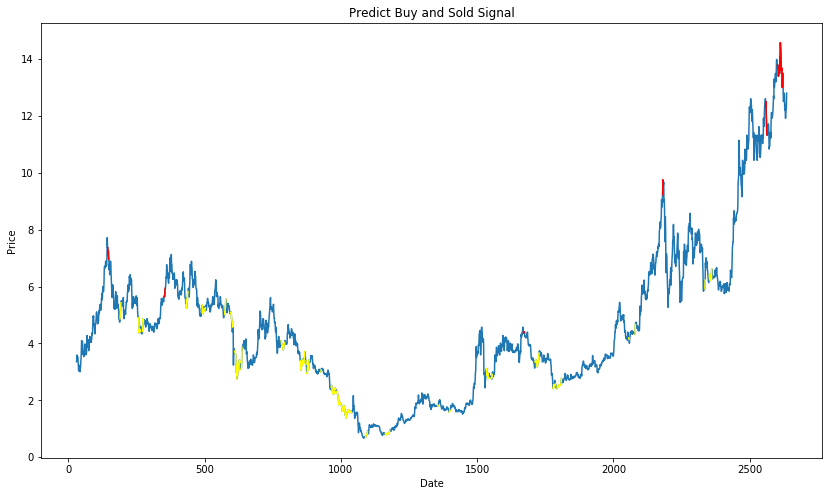

In [11]:
p_test = test_list[0]
p_test = signal_to_catagorical(p_test)
x_test = p_test[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','Close_n','AO_n','RSI_n']].values
x_test = add_shift_day(x_test,30)
y_test = p_test['Signal'].values
y_test = y_test.tolist()
del y_test[0:30]
y_test = np.array(y_test)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis = -1)
p_test = p_test.iloc[30:]

p_test['pred'] = y_pred
p_test['pred_b'] = np.where(p_test['pred'] == 0,p_test['Close'],np.nan)
p_test['pred_s'] = np.where(p_test['pred'] == 1,p_test['Close'],np.nan)

plt.figure(figsize=(14,8))
# plt.grid()
plt.title('Predict Buy and Sold Signal')
plt.plot(p_test['Close'])
plt.plot(p_test['pred_b'],color='yellow')
plt.plot(p_test['pred_s'],color='red')
plt.ylabel('Price')
plt.xlabel('Date')